In [28]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import spotipy
import sqlite3
from sklearn.cluster import KMeans
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
import time
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE

In [29]:
def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [30]:
# connect to database
conn = connect_db('data.db')
cur = conn.cursor()

In [31]:
# Get X data (average playlist features)
data_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
feature_cols = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
test_cols = ['pid', 'track_uri', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']

data_rows = cur.execute('select * from avg_features_by_playlist where pid > (select MIN(pid) from avg_features_by_playlist) order by pid').fetchall()


test_pl = cur.execute('''select tracks_in_playlist.pid, tracks_in_playlist.track_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature 
from features_by_track left join tracks_in_playlist on
features_by_track.track_uri = tracks_in_playlist.track_uri 
where pid = (select MIN(pid) from avg_features_by_playlist)''').fetchall()

conn.close()

test_data = pd.DataFrame(test_pl, columns=test_cols)
data = pd.DataFrame(data_rows, columns=data_cols)

print(test_data.head())
print(data.head(5))

   pid               track_uri  danceability  energy  key  loudness  mode  \
0    0  0UaMYEvWZi0ZqiDOoHU3YI         0.904   0.813  4.0    -7.105   0.0   
1    0  6I9VzXrHxO9rA9A5euc8Ak         0.774   0.838  5.0    -3.914   0.0   
2    0  0WqIKmW4BTrj3eJFmnCKMv         0.664   0.758  2.0    -6.583   0.0   
3    0  1AWQoqb9bSvzTjaLralEkT         0.892   0.714  4.0    -6.055   0.0   
4    0  1lzr43nnXAijIGYnCT8M8H         0.853   0.606  0.0    -4.596   1.0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.1210       0.03110          0.006970    0.0471    0.810  125.461   
1       0.1140       0.02490          0.025000    0.2420    0.924  143.040   
2       0.2100       0.00238          0.000000    0.0598    0.701   99.259   
3       0.1410       0.20100          0.000234    0.0521    0.817  100.972   
4       0.0713       0.05610          0.000000    0.3130    0.654   94.759   

   duration_ms  time_signature  
0       226864               4  
1 

In [32]:
# Scale the data


y = test_data[feature_cols].mean()

scaler = StandardScaler(with_mean=True, with_std=True).fit(data[feature_cols].values)

scaled_x = scaler.transform(data[feature_cols].values)
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
scaled_features = pd.DataFrame(scaled_x)
tsne = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
tsne_transformer = tsne.fit(scaled_x)
data_df = pd.DataFrame(tsne_transformer.transform(scaled_x), columns =['X', 'Y'])

print(data_df)

             X          Y
0    12.580295  -3.567152
1   -11.277246  10.970150
2    13.679773   0.667116
3     5.647542   2.457593
4   -16.290872  -2.231996
..         ...        ...
994   2.847278  -7.181450
995 -14.780181  24.163874
996 -30.095668   7.961921
997   2.701721   4.956539
998  25.293524  15.659318

[999 rows x 2 columns]


<AxesSubplot:xlabel='X', ylabel='Y'>

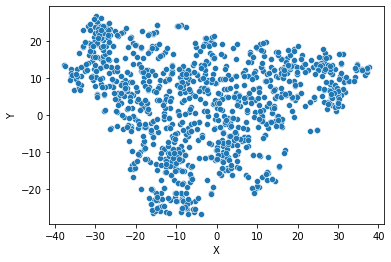

In [33]:
sns.scatterplot(x='X', y='Y', data=data_df, legend=None)

In [34]:
# initialize KMeans
kmeans = KMeans(n_clusters=18, random_state=0)
clusters = kmeans.fit(scaled_x)
labels = clusters.labels_
data_df['cluster'] = pd.Categorical(labels)


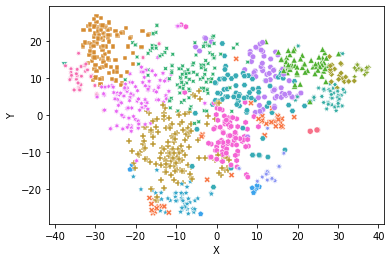

In [35]:
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=data_df, legend=None)
plt.show()

In [36]:
data_df

,X,Y,cluster
0,12.580295,-3.567152,13
1,-11.277246,10.970150,15
2,13.679773,0.667116,10
3,5.647542,2.457593,10
4,-16.290872,-2.231996,15
...,...,...,...
994,2.847278,-7.181450,16
995,-14.780181,24.163874,7
996,-30.095668,7.961921,17
997,2.701721,4.956539,10


,X,Y,cluster,playlist_name
0,12.580295,-3.567152,13,Awesome Playlist
1,-11.277246,10.970150,15,korean
2,13.679773,0.667116,10,mat
3,5.647542,2.457593,10,90s
4,-16.290872,-2.231996,15,Wedding
...,...,...,...,...
994,2.847278,-7.181450,16,old
995,-14.780181,24.163874,7,Daze
996,-30.095668,7.961921,17,rap
997,2.701721,4.956539,10,Country


Index(['X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='object')


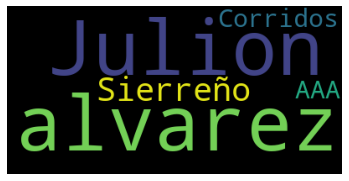

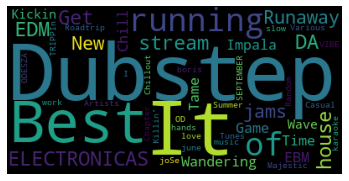

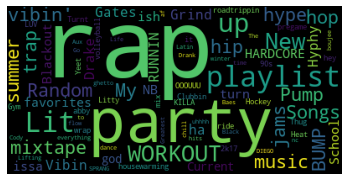

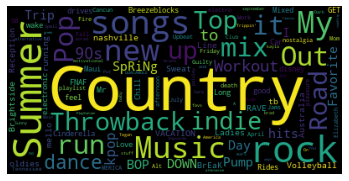

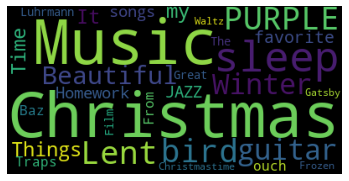

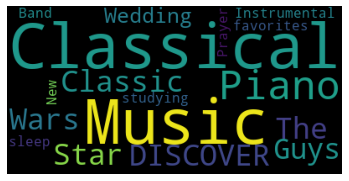

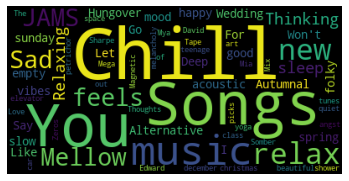

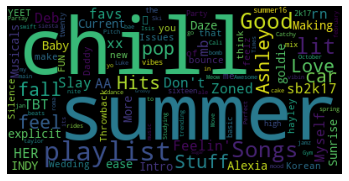

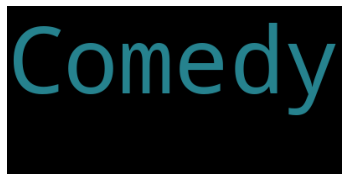

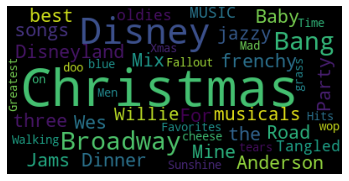

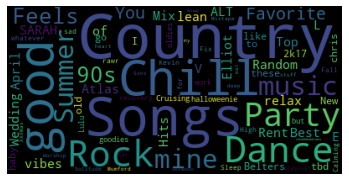

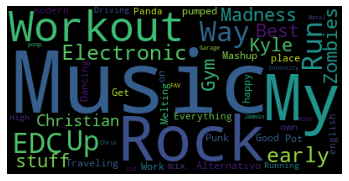

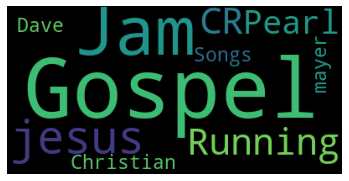

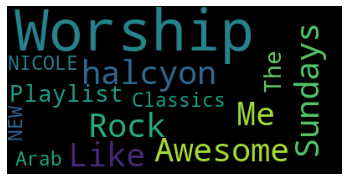

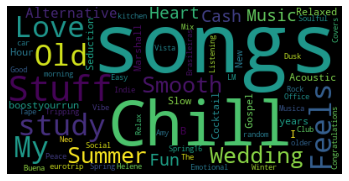

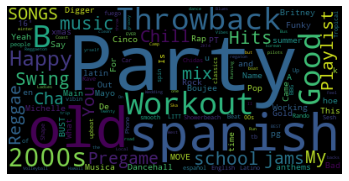

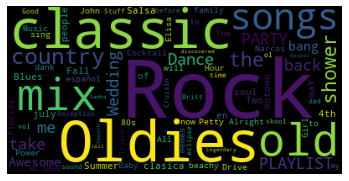

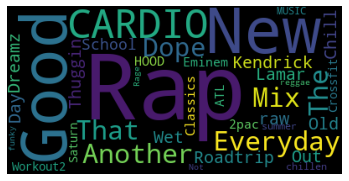

In [68]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

data_df["playlist_name"] = data['name']
# display(data_df)

# we want to perform a pivot on data_df so that each cluster number is a column with row value equal to the playlist name.
# from there we can sum up that column to get the whole lsit of strings of playlist names for each cluster (column)
original_df = data_df.pivot(index='X', columns='cluster')['playlist_name'].reset_index()
original_df.columns.name = None
original_df = original_df.fillna('')
# original_df.head(20)
# print(original_df.columns)

wordclouds = {}
for i in range(18):
    original_df.replace(np.nan, '')
    original_df[i] = original_df[i].astype(str) #.sum(skipna=True))
    wordclouds["wordcloud" + str(i)] = WordCloud(stopwords='stopwords.txt').generate(' '.join(original_df[i]))

for val in wordclouds.values():
    plt.imshow(val)
    plt.axis("off")
    plt.show()


In [66]:
type(original_df[0][0])



float